In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
from IPython import display
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList()
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        
    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [3]:
def derivatives_1(x, Net, func):
    
    w = Net(x)*(func(x).view(-1,1))
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return w, dw_x, dw_y

In [4]:
def derivatives_2(x, Net, func):
    
    w = Net(x)*(func(x).view(-1,1))
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)
    
    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)
 
    return w, dw_x, dw_y, dw_xx, dw_yy, dw_xy

In [5]:
# Calculate the Transformed matrix
def transformed_matrix(phi,opt):

    anpha=phi*3.1415926535/180 # convert degree to radian
    m=math.cos(anpha)
    n=math.sin(anpha)
    if abs(m) < 2.2204e-10:
        m=0
    if abs(n) < 2.2204e-10:
        n=0    

    
    if opt==1:
        T = np.array([[m**2, n**2, 2*m*n ],
                   [n**2, m**2, -2*m*n ],
                   [-m*n, m*n, m**2-n**2]])
    else:
        T = np.array([[m**2, n**2, m*n ],
                   [n**2, m**2, -m*n ],
                   [-2*m*n, 2*m*n, m**2-n**2]])
    return T

In [6]:
a = 5
b = 5
h = 1
n_layer = 2
t = h/n_layer
phi = [0,90]
# q = q * torch.sin(3.1415/a*x[:,0]).view(-1,1)* torch.sin(3.1415/b*x[:,1]).view(-1,1)
q0 = 1e-3 #* torch.sin(3.1415/2*(x[:,0]+1)).view(-1,1)* torch.sin(3.1415/2*(x[:,1]+1)).view(-1,1)
E1 = 25
E2 = E1/25
G12 = 0.5*E2
mu12 = 0.25
mu21 = mu12*E2/E1

Q11 = E1/(1 - mu12*mu21)
Q12 = mu12*E2/(1 - mu12*mu21)
Q22 = E2/(1 - mu12*mu21)
Q66 = G12    
Q = np.array([[Q11, Q12 , 0],[Q12 , Q22, 0],[0, 0, Q66]])
Q_bar =[]
for i in range(n_layer):
        T2=transformed_matrix(phi[i],2)
        Q2=T2.T@Q@T2
        Q_bar.append(Q2)
        
z2 = []
for i in range(n_layer):
    zi=((i+1)-n_layer/2)*t
    z2.append(zi)
z1 = []
for i in range(n_layer):
    zi=((i)-n_layer/2)*t
    z1.append(zi)
z2 = np.array(z2)
z1 = np.array(z1)

A = np.zeros(shape=(3,3))
B = np.zeros(shape=(3,3))
D = np.zeros(shape=(3,3))

for i in range(n_layer):
    A = A + Q_bar[i] * (z2[i] - z1[i])
    B = B + Q_bar[i] * (z2[i]**2 - z1[i]**2)/2
    D = D + Q_bar[i] * (z2[i]**3 - z1[i]**3)/3
 
A, B, D

(array([[13.03258145,  0.25062657,  0.        ],
        [ 0.25062657, 13.03258145,  0.        ],
        [ 0.        ,  0.        ,  0.5       ]]),
 array([[-3.0075188,  0.       ,  0.       ],
        [ 0.       ,  3.0075188,  0.       ],
        [ 0.       ,  0.       ,  0.       ]]),
 array([[1.08604845, 0.02088555, 0.        ],
        [0.02088555, 1.08604845, 0.        ],
        [0.        , 0.        , 0.04166667]]))

In [7]:
def Energy_density(x, Net_w, func_w, Net_u, func_u, Net_v, func_v):
    
    q = q0# * torch.sin(3.1415/2*(x[:,0]+1)).view(-1,1)* torch.sin(3.1415/2*(x[:,1]+1)).view(-1,1)

    w, dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, Net_w, func_w)
    _, du_x, du_y = derivatives_1(x, Net_u, func_u)
    _, dv_x, dv_y = derivatives_1(x, Net_v, func_v)
    
    w = w*h
    dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
    
    eps_xx = du_x + 0.5*dw_x**2
    eps_yy = dv_y + 0.5*dw_y**2
    eps_xy = 0.5*(du_y + dv_x) + 0.5*dw_y*dw_x   
        
    k_xx = -dw_xx
    k_yy = -dw_yy
    k_xy = -dw_xy
    
   # constitutive = (eps_xx, eps_yy, 2*eps_xy, -dw_xx, -dw_yy, 2*-dw_xy)
   # constitutive = np.array(constitutive)
   # constitutive = constitutive.reshape(-1,1)

    #N_xx = A11*du_x + A12*dv_y + B11*k_xx
    #N_yy = A12*du_x + A22*dv_y + B22*k_yy
    #N_xy = A66*(du_y + dv_x) 
    
    N_xx = A[0,0]*eps_xx + A[0,1]*eps_yy + A[0,2]*2*eps_xy  + B[0,0]*k_xx + B[0,1]*k_yy + B[0,2]*2*k_xy 
    N_yy = A[1,0]*eps_xx + A[1,1]*eps_yy + A[1,2]*2*eps_xy  + B[1,0]*k_xx + B[1,1]*k_yy + B[1,2]*2*k_xy 
    N_xy = A[2,0]*eps_xx + A[2,1]*eps_yy + A[2,2]*2*eps_xy  + B[2,0]*k_xx + B[2,1]*k_yy + B[2,2]*2*k_xy 
   
    M_xx = B[0,0]*eps_xx + B[0,1]*eps_yy + B[0,2]*2*eps_xy  + D[0,0]*k_xx + D[0,1]*k_yy + D[0,2]*2*k_xy
    M_yy = B[1,0]*eps_xx + B[1,1]*eps_yy + B[1,2]*2*eps_xy  + D[1,0]*k_xx + D[1,1]*k_yy + D[1,2]*2*k_xy
    M_xy = B[2,0]*eps_xx + B[2,1]*eps_yy + B[2,2]*2*eps_xy  + D[2,0]*k_xx + D[2,1]*k_yy + D[2,2]*2*k_xy
    
    #U_m = 0.5*C*(eps_xx**2 + eps_yy**2 + 2*mu*eps_xx*eps_yy + 2*(1-mu)*eps_xy**2)
    #U_b = 0.5*D*(k_xx**2 + k_yy**2 + 2*mu*k_xx*k_yy + 2*(1-mu)*k_xy**2)
    
    U_m = 0.5*(eps_xx*N_xx + eps_yy*N_yy + 2*eps_xy*N_xy)
    U_b = 0.5*(k_xx*M_xx + k_yy*M_yy + 2*k_xy*M_xy)
    U_e = q*w 
    
    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e)

In [8]:
def train_data(Nx, Ny, N, Nf):
    
    x1 = np.linspace(-1, 1, Nx).reshape([Nx, 1])
    y1 = np.linspace(-1, 1, Ny).reshape([Ny, 1])
    x2 = np.linspace(-1, 1, N).reshape([N, 1])
    y2 = np.linspace(-1, 1, N).reshape([N, 1])
    
    left_boundary = np.column_stack([-np.ones(N), y2])
    right_boundary = np.column_stack([np.ones(N), y2])
    bottom_boundary = np.column_stack([x2, -np.ones(N)])
    top_boundary = np.column_stack([x2, np.ones(N)])
    Xb = np.vstack([left_boundary, right_boundary, bottom_boundary, top_boundary])
    Xb = torch.tensor(Xb, dtype=torch.float32, requires_grad=True)
    
    X, Y = np.meshgrid(x1, y1)
    Xf1 = np.vstack([X.ravel(), Y.ravel()]).T
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)
    #Xf1 = torch.cat([Xf1,Xb],axis = 0)

    Xf2 = np.random.rand(Nf,2)*2-1
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)
    #Xf2 = torch.cat([Xf2,Xb],axis = 0)
    
    return Xb, Xf1, Xf2

In [9]:
# Prepare training data
Nx1 = 100
Ny1 = 100
N1 =1000
Nf1 = 10000

Xb, Xf1, Xf2 = train_data(Nx1, Ny1, N1, Nf1)
#X_int, _ = train_data(Nx2, Ny2, Nf2)

#print(X_int)
# Construct neural network
Net_w = Net(2, 1, 5, 5)
Net_u = Net(2, 1, 5, 5)
Net_v = Net(2, 1, 5, 5)

func_w = lambda x: ((x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1))**2
func_u = lambda x: (x[:,1]+1)*(x[:,1]-1)*(x[:,0]+1)*(x[:,0]-1)
func_v = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)

In [10]:
import pandas as pd
data = pd.read_csv('Training_Data.csv')

X_inp = data.iloc[:,1:3].to_numpy()

X_inp = torch.tensor(X_inp, dtype=torch.float32, requires_grad=True)
X_inp = X_inp/50

In [11]:
# Construct neural network
# optimizer
nepoches = 10000
initial_epochs = 100
learning_rate = 1e-3
hist = []
training_loss = []
W_pred_hist = []
# optimizer_w = torch.optim.Adam(Net_w.parameters(), lr=learning_rate)
# optimizer_f = torch.optim.Adam(Net_f.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()), 
                             lr= learning_rate)
for epoch in range(nepoches):
        
    if epoch < initial_epochs:
        _, Xf1, _ = train_data(Nx1, Ny1, N1, Nf1)
        Xf = Xf1
    else:
        _, _, Xf2 = train_data(Nx1, Ny1, N1, Nf1)
        Xf = Xf2

    U_m, U_b, U_e = Energy_density(Xf, Net_w, func_w, Net_u, func_u, Net_v, func_v)
    
    loss = U_m + U_b - U_e
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    hist.append(loss.item())   
        
    if (epoch+1) % 1 ==0: 
        with torch.no_grad():
            W_pred = Net_w(X_inp)*func_w(X_inp).view(-1,1)*100*(h)**3*E2/q0/(2*a)**4
            error = abs((max(W_pred)-0.3954)/0.3954)
            training_loss.append(error)
            W_pred_hist.append(max(W_pred))
            
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total:{loss:.4e}, Membrane:{U_m:.4e}, Bending:{U_b:.4e}, External:{U_e:.4e}, W:{max(W_pred)}')

epoch:100, Total:8.4779e-03, Membrane:8.4134e-03, Bending:-8.3680e-06, External:-7.2911e-05, W:tensor([-0.])
epoch:200, Total:3.7833e-03, Membrane:3.7543e-03, Bending:-2.9517e-05, External:-5.8498e-05, W:tensor([-0.])
epoch:300, Total:1.9176e-03, Membrane:1.8952e-03, Bending:-2.3800e-05, External:-4.6110e-05, W:tensor([-0.])
epoch:400, Total:1.0098e-03, Membrane:9.8993e-04, Bending:-1.4889e-05, External:-3.4799e-05, W:tensor([-0.])
epoch:500, Total:5.7828e-04, Membrane:5.6552e-04, Bending:-1.1768e-05, External:-2.4532e-05, W:tensor([-0.])
epoch:600, Total:3.5433e-04, Membrane:3.4633e-04, Bending:-7.9772e-06, External:-1.5980e-05, W:tensor([-0.])
epoch:700, Total:2.2816e-04, Membrane:2.2418e-04, Bending:-5.0643e-06, External:-9.0504e-06, W:tensor([-0.])
epoch:800, Total:1.5997e-04, Membrane:1.5871e-04, Bending:-2.7392e-06, External:-3.9975e-06, W:tensor([-0.])
epoch:900, Total:1.1925e-04, Membrane:1.2032e-04, Bending:-8.9630e-07, External:1.7019e-07, W:tensor([0.0486])
epoch:1000, Total

epoch:7500, Total:-5.4226e-06, Membrane:2.7736e-07, Bending:5.5808e-06, External:1.1281e-05, W:tensor([0.3868])
epoch:7600, Total:-5.1981e-06, Membrane:3.3434e-07, Bending:5.4985e-06, External:1.1031e-05, W:tensor([0.3909])
epoch:7700, Total:-5.4037e-06, Membrane:2.2242e-07, Bending:5.6268e-06, External:1.1253e-05, W:tensor([0.3910])
epoch:7800, Total:-5.4068e-06, Membrane:9.0242e-08, Bending:5.8760e-06, External:1.1373e-05, W:tensor([0.3925])
epoch:7900, Total:-5.5211e-06, Membrane:-3.2138e-08, Bending:6.1479e-06, External:1.1637e-05, W:tensor([0.3950])
epoch:8000, Total:-5.5188e-06, Membrane:2.9701e-07, Bending:5.4606e-06, External:1.1276e-05, W:tensor([0.3898])
epoch:8100, Total:-5.6586e-06, Membrane:1.5932e-07, Bending:5.6045e-06, External:1.1422e-05, W:tensor([0.3924])
epoch:8200, Total:-5.4980e-06, Membrane:3.0036e-07, Bending:5.3411e-06, External:1.1139e-05, W:tensor([0.3890])
epoch:8300, Total:-5.4693e-06, Membrane:-2.3243e-08, Bending:6.0068e-06, External:1.1453e-05, W:tensor(

In [138]:
W = Net_w(X_inp)*(func_w(X_inp).view(-1,1))*100*(h)**3*E2/q0/(2*a)**4
U = Net_u(X_inp)*(func_u(X_inp).view(-1,1))
V = Net_v(X_inp)*(func_v(X_inp).view(-1,1))

W = W.detach().numpy().reshape(-1,1)*1
V = V.detach().numpy().reshape(-1,1)*5
U = U.detach().numpy().reshape(-1,1)*5

X = X_inp[:,0].detach().numpy().reshape(-1,1)*5
Y = X_inp[:,1].detach().numpy().reshape(-1,1)*5

In [139]:
df_out = pd.DataFrame(W_pred_hist, columns=['max_W'])
df_out.to_csv('Part1_0-90_10000_max_W.csv')

W = W.reshape(-1, 1)
df_W = pd.DataFrame(W, columns=['W'])
df_W.to_csv('Part1_0-90_10000_W.csv')
            
df_hist = pd.DataFrame(hist, columns=['loss'])
df_hist.to_csv('Part1_0-90_10000_hist.csv', index=False)

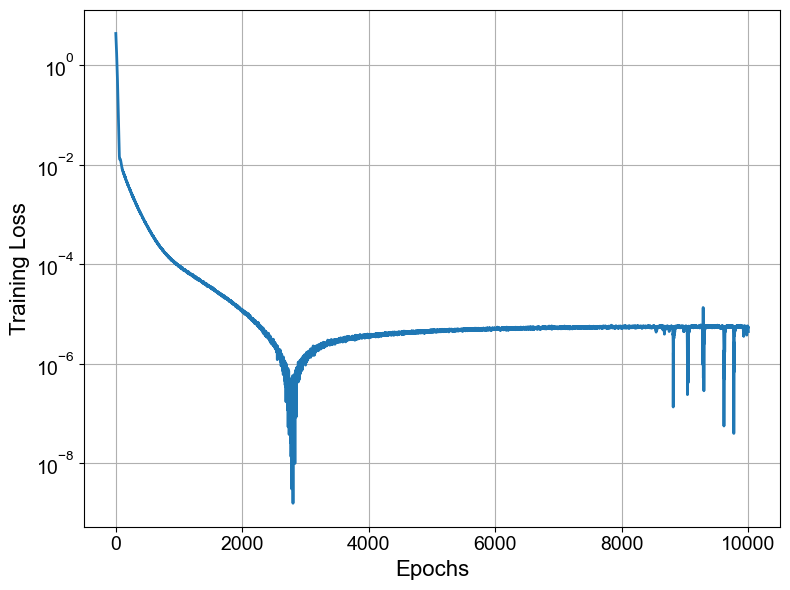

In [142]:
absList = list(map(abs, hist))
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(8, 6))
absList_smoothed1 = pd.Series(absList).rolling(window=10).mean()

plt.plot(absList, label='Loss', color='#1f77b4', linewidth=2)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Training Loss", fontsize=16)
plt.yscale('log')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.savefig("Part1_Loss_Curve.svg", dpi=600, format="svg", bbox_inches='tight')
plt.show()

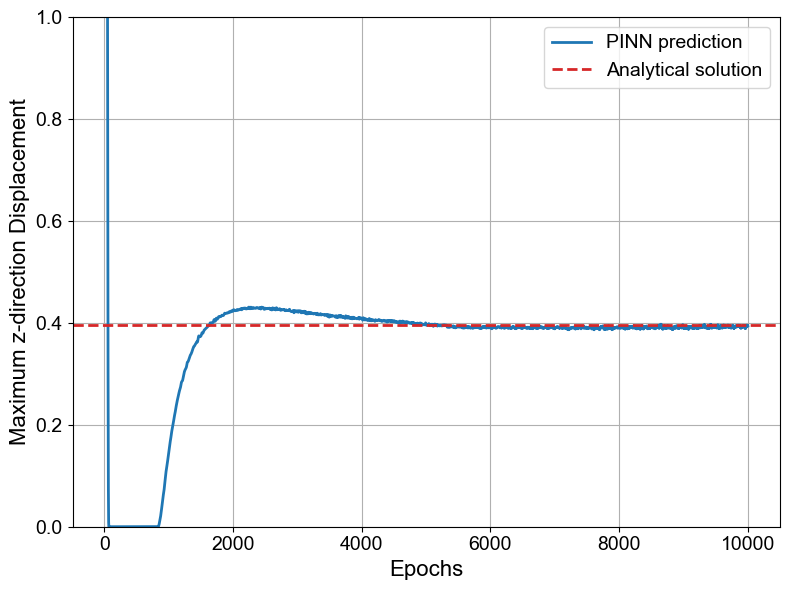

In [143]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(8, 6))
W_pred_hist_smoothed = pd.Series(W_pred_hist).rolling(window=10).mean()
plt.plot(W_pred_hist_smoothed, label='PINN prediction', color='#1f77b4', linewidth=2)
plt.axhline(0.3954, color="#d62728", linestyle="--", linewidth=2, label='Analytical solution')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel('Maximum z-direction Displacement', fontsize=16)
ax = plt.gca()
ax.set_ylim(0, 1.0)  
plt.grid(True)
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()

plt.savefig("Part1_Deflection_Curve.svg", dpi=600, format="svg", bbox_inches='tight')
plt.show()

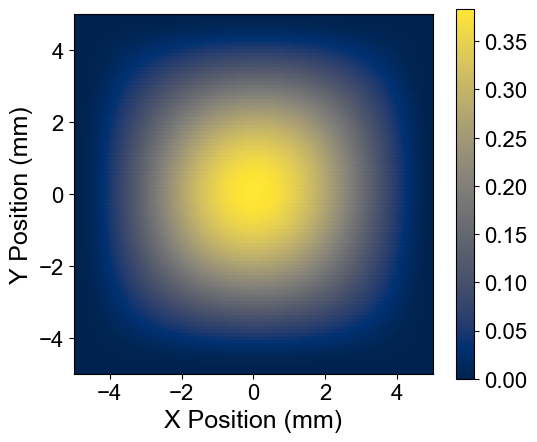

In [140]:
plt.rcParams['font.family'] = 'Arial'


fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c=W, vmin=0, cmap=cm.cividis)

cb = fig.colorbar(surf, ax=ax, orientation='vertical')
cb.ax.tick_params(labelsize=16)

ax.axis('equal')  
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.min(), Y.max()])

ax.set_aspect('equal', adjustable='box')
plt.savefig("Part1_2D.svg", dpi=600, format="svg", bbox_inches='tight')

plt.show()

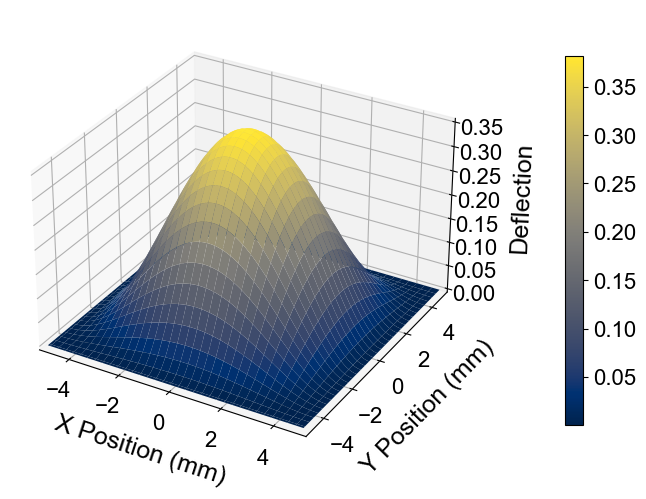

In [141]:
X = X_inp[:,0].detach().numpy().reshape(-1,1) * 5
Y = X_inp[:,1].detach().numpy().reshape(-1,1) * 5
X1 = X.reshape(101, 101)
Y1 = Y.reshape(101, 101)
W1 = W.reshape(101, 101)

plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X1, Y1, W1, cmap=cm.cividis, edgecolor='none')

cb = fig.colorbar(surf,fraction=0.046, pad=0.15, shrink=0.8)
cb.ax.tick_params(labelsize=16)

ax.set_xlabel('X Position (mm)', fontsize=18, labelpad=10)
ax.set_ylabel('Y Position (mm)', fontsize=18, labelpad=10)
ax.set_zlabel('Deflection', fontsize=18, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.min(), Y.max()])
ax.set_zlim(0.00, 0.35)
ax.zaxis.set_major_locator(plt.MultipleLocator(0.05))  
ax.set_zticks(np.arange(0.00, 0.36, 0.05))  

ax.view_init(elev=30, azim=-60)
ax.set_box_aspect([1.5, 1.5, 1])  

plt.savefig("Part1_3D.svg", dpi=600, format="svg", bbox_inches='tight')
plt.show()

In [131]:
w, dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(X_inp, Net_w, func_w)
_, du_x, du_y = derivatives_1(X_inp, Net_u, func_u)
_, dv_x, dv_y = derivatives_1(X_inp, Net_v, func_v)

w = w*h
dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

eps_xx = du_x + 0.5*dw_x**2
eps_yy = dv_y + 0.5*dw_y**2
eps_xy = 0.5*(du_y + dv_x) + 0.5*dw_y*dw_x   

k_xx = -dw_xx
k_yy = -dw_yy
k_xy = -dw_xy

N_xx = A[0,0]*eps_xx + A[0,1]*eps_yy + A[0,2]*2*eps_xy  + B[0,0]*k_xx + B[0,1]*k_yy + B[0,2]*2*k_xy 
N_yy = A[1,0]*eps_xx + A[1,1]*eps_yy + A[1,2]*2*eps_xy  + B[1,0]*k_xx + B[1,1]*k_yy + B[1,2]*2*k_xy 
N_xy = A[2,0]*eps_xx + A[2,1]*eps_yy + A[2,2]*2*eps_xy  + B[2,0]*k_xx + B[2,1]*k_yy + B[2,2]*2*k_xy 

M_xx = B[0,0]*eps_xx + B[0,1]*eps_yy + B[0,2]*2*eps_xy  + D[0,0]*k_xx + D[0,1]*k_yy + D[0,2]*2*k_xy
M_yy = B[1,0]*eps_xx + B[1,1]*eps_yy + B[1,2]*2*eps_xy  + D[1,0]*k_xx + D[1,1]*k_yy + D[1,2]*2*k_xy
M_xy = B[2,0]*eps_xx + B[2,1]*eps_yy + B[2,2]*2*eps_xy  + D[2,0]*k_xx + D[2,1]*k_yy + D[2,2]*2*k_xy

In [135]:
M_yy[50]/q0/(2*a)**2

tensor([-0.0544], grad_fn=<DivBackward0>)

In [137]:
M_xx[5150]/q0/(2*a)**2

tensor([-0.0176], grad_fn=<DivBackward0>)

In [145]:
data = pd.read_csv('Part1_0-90_10000_max_W.csv')
W_pred_hist_10000 = data.iloc[:, 1].apply(lambda x: float(x.split('(')[1].split(')')[0]))
data = pd.read_csv('Part1_0-90_5000_max_W.csv')
W_pred_hist_5000 = data.iloc[:, 1].apply(lambda x: float(x.split('(')[1].split(')')[0]))
data = pd.read_csv('Part1_0-90_1000_max_W.csv')
W_pred_hist_1000 = data.iloc[:, 1].apply(lambda x: float(x.split('(')[1].split(')')[0]))
W_pred_hist_10000_transformed = abs((W_pred_hist_10000 - 0.3954) / 0.3954)
W_pred_hist_5000_transformed = abs((W_pred_hist_5000 - 0.3954) / 0.3954)
W_pred_hist_1000_transformed = abs((W_pred_hist_1000 - 0.3954) / 0.3954)

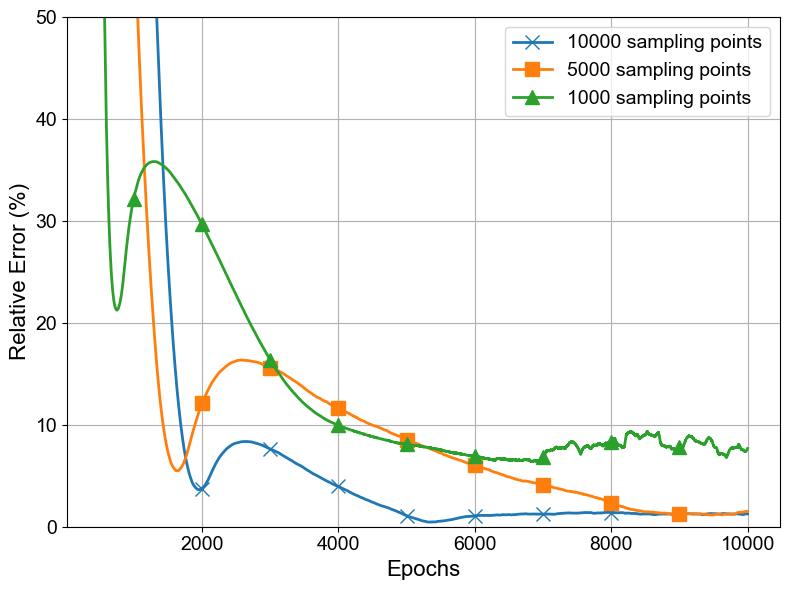

In [149]:
plt.figure(figsize=(8, 6))

W_pred_hist_10000_transformed_s = pd.Series(W_pred_hist_10000_transformed).rolling(window=500).mean() * 100
W_pred_hist_5000_transformed_s = pd.Series(W_pred_hist_5000_transformed).rolling(window=500).mean() * 100
W_pred_hist_1000_transformed_s = pd.Series(W_pred_hist_1000_transformed).rolling(window=500).mean() * 100

plt.plot(W_pred_hist_10000_transformed_s, label='10000 sampling points', color='#1f77b4', linewidth=2, marker='x', markersize=10, markevery=1000)
plt.plot(W_pred_hist_5000_transformed_s, label='5000 sampling points', color='#ff7f0e', linewidth=2, marker='s', markersize=10, markevery=1000)
plt.plot(W_pred_hist_1000_transformed_s, label='1000 sampling points', color='#2ca02c', linewidth=2, marker='^', markersize=10, markevery=1000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel('Relative Error (%)', fontsize=16)
plt.ylim(0, 50)
plt.grid(True)
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig("Part1_SamplingSize.svg", dpi=600, format="svg", bbox_inches='tight')
plt.show()